## This notebook is written for purposes of optimization and bottleneck solving

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd workspace/theislab/mubind/notebooks/optimize

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/optimize


In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [4]:
import os

df = []
basedir = '../../../mubind-pipeline/output/snakemake/SELEX'
batch = 0

n_sample = 100
counts_by_dataset = []
for tf in os.listdir(basedir):
    for f in os.listdir(os.path.join(basedir, tf)):
        if f.endswith('.tsv.gz'):

            if not '1000' in f:
                continue

            df2 = pd.read_csv(os.path.join(basedir, tf, f), sep='\t', index_col=0) # .head(10)
            print(f)
            assert 'batch' in df2
            # print(df2.columns)
            n_rounds = len(df2.columns) - 2
            sums = df2[df2.columns[:-3]].sum(axis=0)
            counts_by_dataset.append(sums)
            df2.columns =  list(range(n_rounds)) + ['batch', 'is_count_data']

            df2 = df2[~df2.index.str.contains('N')]
            df2 = df2.sample(min(n_sample, df2.shape[0]))

            df2['batch'] = batch
            df2['n_rounds'] = n_rounds
            batch += 1
            df.append(df2)

    # if len(df) > 10:
    #     break


# concatenation/reordering
df = pd.concat(df)
df = df[[c for c in df.columns if not c in ['batch', 'is_count_data', 'n_rounds']] + ['batch', 'is_count_data', 'n_rounds']]

# total reads
sum(pd.concat(counts_by_dataset).drop_duplicates().sort_values(ascending=False))

ALX1-ZeroCycle_TACCAA40NTTA_0_0-TACCAA40NTTA_1000.tsv.gz
ALX1-ZeroCycle_TCCTTG40NGGT_0_0-TCCTTG40NGGT_1000.tsv.gz
ALX4-ZeroCycle_ES0_TGTGTC20NGA_0-TGTGTC20NGA_1000.tsv.gz
ALX4-ZeroCycle_TCTATT40NCAT_0_0-TCTATT40NCAT_1000.tsv.gz
ALX4-ZeroCycle_TGCGTA40NTCA_0_0-TGCGTA40NTCA_1000.tsv.gz
ALX4-ZeroCycle_TGTGTC20NGA_0_0-TGTGTC20NGA_1000.tsv.gz
CTCF-ZeroCycle_ES0_TAGCGA20NGCT_0-TAGCGA20NGCT_1000.tsv.gz
CTCF-ZeroCycle_TAGCGA20NGCT_0_0-TAGCGA20NGCT_1000.tsv.gz
EGR1-ZeroCycle_ES0_TACTAT20NATC_0-TACTAT20NATC_1000.tsv.gz
EGR1-ZeroCycle_ES0_TCTCTT20NGA_0-TCTCTT20NGA_1000.tsv.gz
EGR1-ZeroCycle_TACTAT20NATC_0_0-TACTAT20NATC_1000.tsv.gz
EGR1-ZeroCycle_TAGACA40NGTC_0_0-TAGACA40NGTC_1000.tsv.gz
EGR1-ZeroCycle_TCAGCC40NTTC_0_0-TCAGCC40NTTC_1000.tsv.gz
EGR1-ZeroCycle_TCCGCT40NGCG_0_0-TCCGCT40NGCG_1000.tsv.gz
EGR1-ZeroCycle_TCTCTT20NGA_0_0-TCTCTT20NGA_1000.tsv.gz
EGR1-ZeroCycle_TTGTAC40NGTA_0_0-TTGTAC40NGTA_1000.tsv.gz
ELF2-ZeroCycle_TAGGAG40NAGT_0_0-TAGGAG40NAGT_1000.tsv.gz
ELF2-ZeroCycle_TGAAAT40NCAA_0_0

50904

In [5]:
dataset = mb.datasets.SelexDataset(df, n_rounds=df['n_rounds'], labels=list(df.columns[:-3]), store_rev=False)
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=512,
                         shuffle=False)

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np

In [16]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

num_epochs = 3
log_each = 10
n_kernels = 4
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)
w = 15 # min(len(motif), 6)
opt_kernel_shift = 1
opt_kernel_length = 1

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

In [100]:
criterion = mb.tl.PoissonLoss()

n_rounds = train.dataset.n_rounds
n_batches = train.dataset.n_batches
enr_series = train.dataset.enr_series

model = mb.models.Multibind(
    datatype="selex",
    kernels=[0] + [w] * (n_kernels - 1),
    n_rounds=n_rounds,
    init_random=False,
    use_dinuc=True,
    dinuc_mode='full',
    n_batches=n_batches,

    enr_series=enr_series,
).to(device)

next_optimiser = topti.Adam(model.parameters(), lr=lr[0], weight_decay=wd[0])


In [101]:
model.binding_modes

BindingModesSimple(
  (conv_mono): ModuleList(
    (0): None
    (1): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
    (2): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
    (3): Conv2d(1, 1, kernel_size=(4, 15), stride=(1, 1), bias=False)
  )
  (conv_di): ModuleList(
    (0): None
    (1): ModuleList(
      (0): Conv2d(1, 1, kernel_size=(16, 14), stride=(1, 1))
      (1): Conv2d(1, 1, kernel_size=(16, 13), stride=(1, 1))
      (2): Conv2d(1, 1, kernel_size=(16, 12), stride=(1, 1))
      (3): Conv2d(1, 1, kernel_size=(16, 11), stride=(1, 1))
      (4): Conv2d(1, 1, kernel_size=(16, 10), stride=(1, 1))
      (5): Conv2d(1, 1, kernel_size=(16, 9), stride=(1, 1))
      (6): Conv2d(1, 1, kernel_size=(16, 8), stride=(1, 1))
      (7): Conv2d(1, 1, kernel_size=(16, 7), stride=(1, 1))
      (8): Conv2d(1, 1, kernel_size=(16, 6), stride=(1, 1))
      (9): Conv2d(1, 1, kernel_size=(16, 5), stride=(1, 1))
      (10): Conv2d(1, 1, kernel_size=(16, 4), stride=(1, 1))

In [25]:
%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [112]:
%lprun -f model.binding_modes.forward mb.tl.optimize_simple(model, train, device, next_optimiser, criterion, num_epochs=num_epochs, early_stopping=early_stopping[0], log_each=log_each, dirichlet_regularization=dirichlet_regularization, exp_max=40, verbose=1)

optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 3 
early_stopping: 5
lr= 0.01, weight_decay= 0.01, dir weight= 0
Final loss: 6.4636704858
Total time (model/function): (3.271s / 3.271s)
Time per epoch (model/function): (1.635s/ 1.635s)
Time per epoch per 1k trials: 0.204s
Current time: 2023-01-02 13:09:22.398024


torch.Size([8000, 1, 4, 40])

In [50]:
ki = 20
mono = train.dataset.mononuc
mono = torch.tensor(mono, device=device).unsqueeze(1)
mono_cpu = mono.to('cpu')
print(mono.shape)
p = mono[:, :, :, :mono.shape[-1] - ki]
p_cpu = mono[:, :, :, :mono.shape[-1] - ki]

torch.Size([8000, 1, 4, 40])


In [ ]:
%time torch.argmax(p, axis=2)
%time torch.argmax(p_cpu, axis=2)

In [83]:
p_max = torch.argmax(p, axis=2)

In [86]:
torch.nn.functional.one_hot(p_max.flatten(), num_classes=16).shape

torch.Size([160000, 16])

In [111]:
mono = train.dataset.mononuc
mono = torch.tensor(mono, device=device)
model.forward(mono)

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [ ]:
# mb.tl.optimize_simple(model, train, device, next_optimiser, criterion, num_epochs=num_epochs, early_stopping=early_stopping[0], log_each=log_each, dirichlet_regularization=dirichlet_regularization, exp_max=40, verbose=1)

In [237]:
import mubind as mb

In [79]:
%time ii = p.argmax(0); maxval = p.gather(0, ii.unsqueeze(0)).squeeze(0)
maxval

CPU times: user 249 µs, sys: 34 µs, total: 283 µs
Wall time: 181 µs


tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1., 1.]]], device='cuda:0')

In [58]:
model = model_by_k
mb.tl.scores(model, train)


[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


{'r2_counts': 0.14156439819488664,
 'r2_foldchange': 0.0962666305646872,
 'r2_enr': 0.021791620322068717,
 'r2_fc': 0.10256048118399172,
 'pearson_foldchange': 0.32025065368238004}

In [59]:
counts = mb.tl.predict(model, train)
counts

[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


,t0,t1,p0,p1,batch,n_rounds,enr_pred,enr_obs,f_pred,f_obs
ACTTCCATCACGGGTAGGTTGGGAC,0.0,1.0,0.565514,0.434486,0,2,0.916303,2.0,-0.037961,0.30103
ACCGGTGCGACATCCGCCATCGATA,0.0,1.0,0.634643,0.365357,0,2,0.835263,2.0,-0.078177,0.30103
TTACAGGGGCGGATACGGAGGCGGA,0.0,1.0,0.557563,0.442436,0,2,0.926085,2.0,-0.033349,0.30103
AAATGACATATTGCGCGCTGTGCCA,1.0,0.0,0.554503,0.445497,0,2,0.929877,0.5,-0.031574,-0.30103
TAATCGCTCGAAATGATGTTAATAG,0.0,1.0,0.538921,0.461079,0,2,0.949418,2.0,-0.022543,0.30103
...,...,...,...,...,...,...,...,...,...,...
TTTATGTTTAGGGTCTTTCGAACCG,1.0,0.0,0.706419,0.293581,0,2,0.758067,0.5,-0.120292,-0.30103
GGGCTCGGACACCGTAGGAGGCTTG,1.0,0.0,0.581304,0.418696,0,2,0.897168,0.5,-0.047126,-0.30103
TAGTGGTGAGGAGTACGTTTAACGG,0.0,1.0,0.565394,0.434606,0,2,0.916451,2.0,-0.037891,0.30103
GACGGTGGTGTCAGCATGGGCGATG,1.0,0.0,0.640856,0.359144,0,2,0.828314,0.5,-0.081805,-0.30103


[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]


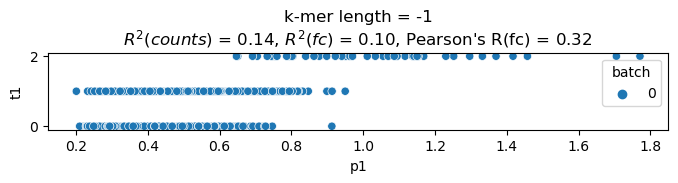

{'r2_counts': 0.14156439819488664,
 'r2_foldchange': 0.0962666305646872,
 'r2_enr': 0.021791620322068717,
 'r2_fc': 0.10256048118399172,
 'pearson_foldchange': 0.32025065368238004}

In [60]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')



#activities
[[[1.0000745  0.90032023]
  [1.         0.5846111 ]]]

#log_etas
Parameter containing:
tensor([[ 1.1396, -1.1396]], device='cuda:0', requires_grad=True)


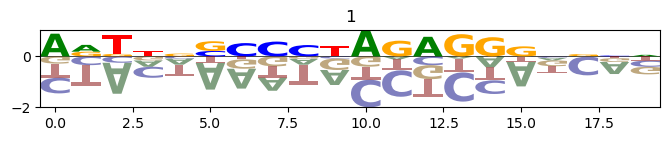

In [61]:
mb.pl.conv_mono(model)


In [35]:
# Compare four implementations for the forward function at selexmodule (do not delete)
from numba import jit, objmode
# @jit
def mult1_torch(B, A, S, categories, p):
    for i in range(p):
        # print(np.matmul(B[categories == i], A[i,:,:]).shape, S[categories == i].shape)
        S[categories == i] = torch.matmul(B[categories == i], A[i,:,:])
    return torch.sum(S)

# @jit
def mult1_np(B, A, S, categories, p):
    for i in range(p):
        # print(np.matmul(B[categories == i], A[i,:,:]).shape, S[categories == i].shape)
        S[categories == i] = np.matmul(B[categories == i], A[i,:,:])
    return np.sum(S)

# @jit
def mult2_np(B, A, S, categories, p):
    result = np.matmul(np.expand_dims(B, 1), A[categories,:,:])
    result = result.squeeze(1)
    return np.sum(result)

def mult3_np(B, A, S, categories, p):
    bigmask = np.arange(p)[:, np.newaxis] == categories
    C = np.matmul(B_np, A_np)
    res = C[np.broadcast_to(bigmask[..., np.newaxis], C.shape)].reshape(r, q)
    sort_index = np.argsort(np.broadcast_to(np.arange(r), bigmask.shape)[bigmask])
    return np.sum(res[sort_index])


def mult2_torch(B, A, S, categories, p):
    result = torch.matmul(B.unsqueeze(1), A[categories,:,:])
    result = result.squeeze(1)
    return torch.sum(result)

# as tensors
import numpy as np
p = 100
q = 9
r = 50000
t = 4
# data initialization
np.random.seed(500)
# initialize random data
S = torch.rand(r, q)
A = torch.rand((p, t, q))
B = torch.rand(r, t)
categories = torch.randint(0, p, (r,))

S_np = S.detach().numpy()
A_np = A.detach().numpy()
B_np = B.detach().numpy()
categories_np = categories.detach().numpy()

print(S.shape, A.shape, A[categories,:,:].shape, B.shape, categories.shape)
print(S_np.shape, A_np.shape, B_np.shape, categories.shape)
mult2_np(B_np, A_np, S_np, categories_np, p)

%timeit mult1_np(B_np, A_np, S_np, categories_np, p)
%timeit mult2_np(B_np, A_np, S_np, categories_np, p)
%timeit mult3_np(B_np, A_np, S_np, categories_np, p)
# %timeit mult1_torch(B, A, S, categories, p)
# %timeit mult2_torch(B, A, S, categories, p)
# %timeit mult2_np(B, A, S, categories, p)


torch.Size([50000, 9]) torch.Size([100, 4, 9]) torch.Size([50000, 4, 9]) torch.Size([50000, 4]) torch.Size([50000])
(50000, 9) (100, 4, 9) (50000, 4) torch.Size([50000])
453103.7 453103.7 453103.7 tensor(453103.7188) tensor(453103.7500)
24.5 ms ± 3.69 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.01 ms ± 508 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
124 ms ± 2.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
np.arange(p)[:, np.newaxis] == categories_np

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])